In [1]:
import pandas as pd
import time
from datetime import datetime, timedelta
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

In [2]:
#!pip install eli5
#!pip install lightgbm

from eli5.sklearn import PermutationImportance
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

### 1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

Загрузим датасет

In [3]:
train_new = pd.read_csv('dataset/dataset_train.csv', sep=';')

Произведем балансировку классов

In [4]:
X = train_new.drop(['user_id', 'is_churned'], axis=1)
y = train_new['is_churned']

# Нормализация данных
X_mm = MinMaxScaler().fit_transform(X)

In [5]:
# Разобьем датасет на тренировоный и тестовый
X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=42)

In [6]:
# Балансировка классов
X_train_balanced, y_train_balanced = SMOTE(sampling_strategy=0.3, random_state=42, n_jobs=-1).fit_sample(X_train, y_train)

In [7]:
# Просмотр результатов
print('До:', Counter(y_train))
print('После:', Counter(y_train_balanced))

До: Counter({0: 318955, 1: 9677})
После: Counter({0: 318955, 1: 95686})


Отберем признаки методами взаимной информации, RFE и PI. Посмотри качество XGBoost'а по метрике F1

In [8]:
# Функция вычисляющая метрики качества модели
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

# Функция обучения модели и ее предсказания
def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=4,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

# Функция построения графика важности признаков
def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

Для отправной точки возьмем результаты без отбора признаков и посмотрим как будет работать встроенный метод feature_importance.

Precision: 0.3005511539786428
Recall: 0.4206846673095468
F1: 0.3506128189672494
Log Loss: 0.13002259847872516
ROC AUC: 0.9065963154568151


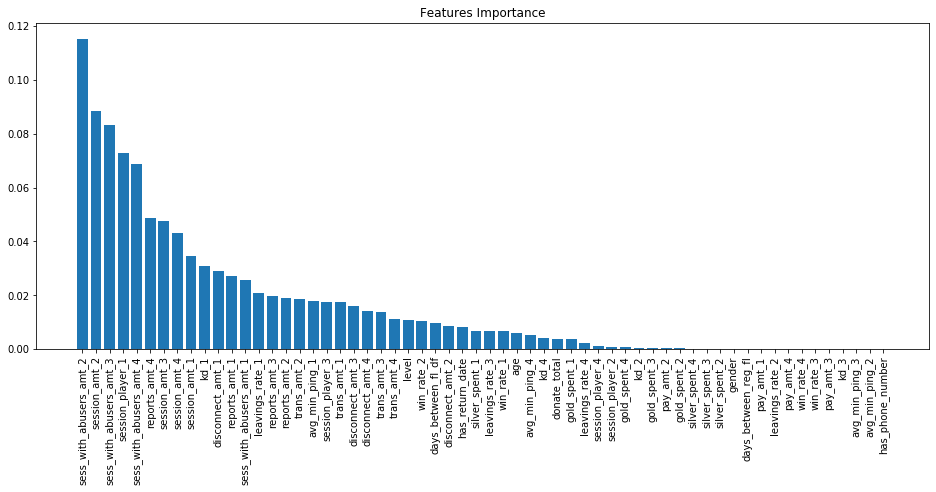

In [9]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

In [10]:
# Построим модель на первых 30 признаках
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

Precision: 0.28824006488240067
Recall: 0.4283992285438766
F1: 0.3446135944923882
Log Loss: 0.13315244272621204
ROC AUC: 0.904712423850224


Взаимная информация

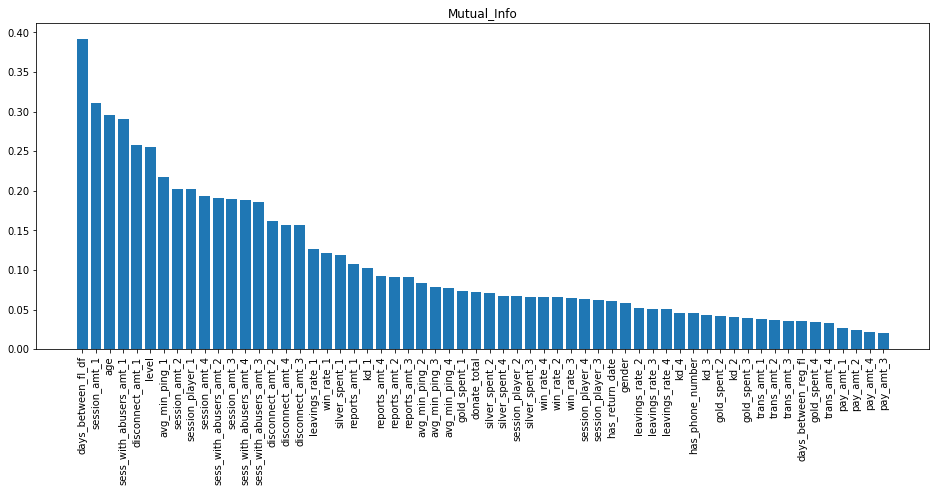

In [11]:
mi = mutual_info_classif(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [12]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

Precision: 0.29685845393575716
Recall: 0.40549662487946
F1: 0.34277562665579786
Log Loss: 0.13175174229221664
ROC AUC: 0.9046884146099071


RFE (Recursive Feature Elimination)

In [13]:
STEP = 6
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print(f"Optimal number of features : {selector.n_features_}")

Optimal number of features : 42


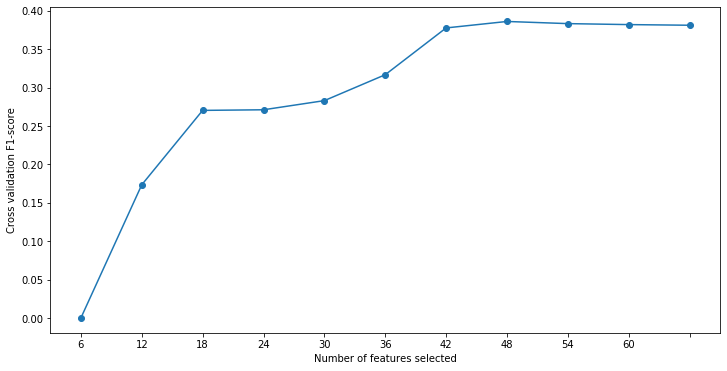

In [14]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [15]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:42]]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:42]]

fitted_clf = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

Precision: 0.2955536181342633
Recall: 0.4086306653809065
F1: 0.34301325508448854
Log Loss: 0.13194706960342834
ROC AUC: 0.9045318946801125


Permutation Importance (PI)

In [16]:
# Проведем заново обучение модели на начальных данных, для того чтобы получить результат не на отобранных
# признаках из предыдущего метода отбора
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

Precision: 0.3005511539786428
Recall: 0.4206846673095468
F1: 0.3506128189672494
Log Loss: 0.13002259847872516
ROC AUC: 0.9065963154568151


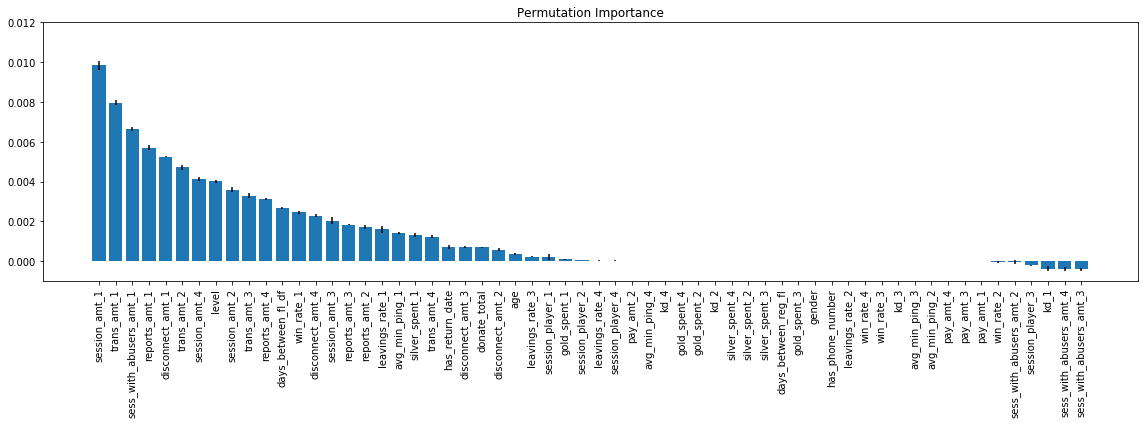

In [17]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [18]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 38


In [19]:
X_train_PI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:38]]
X_test_PI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:38]]

fitted_clf = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

Precision: 0.29506990434142755
Recall: 0.3866923818707811
F1: 0.33472454090150255
Log Loss: 0.13066951706361907
ROC AUC: 0.9034044788842316


Из полученных результатов можно сделать вывод, что из трех методов отбора признаков лучше всего показал себя RFE. Но, если брать все методы, лучше всего результаты у метода модели XGBoost feature_importance.

### 2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

Я решил попробовать обучить модели RandomForestClassifier и LGBMClassifier на встроенных методах отбора признаков.

LGBMClassifier

In [20]:
# Функция обучения модели и ее предсказания
def lgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = lgb.LGBMClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=4,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [21]:
fitted_clf = lgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.3017872340425532
Recall: 0.42743490838958537
F1: 0.3537862915294822
Log Loss: 0.12932749684032088
ROC AUC: 0.9076346289028752


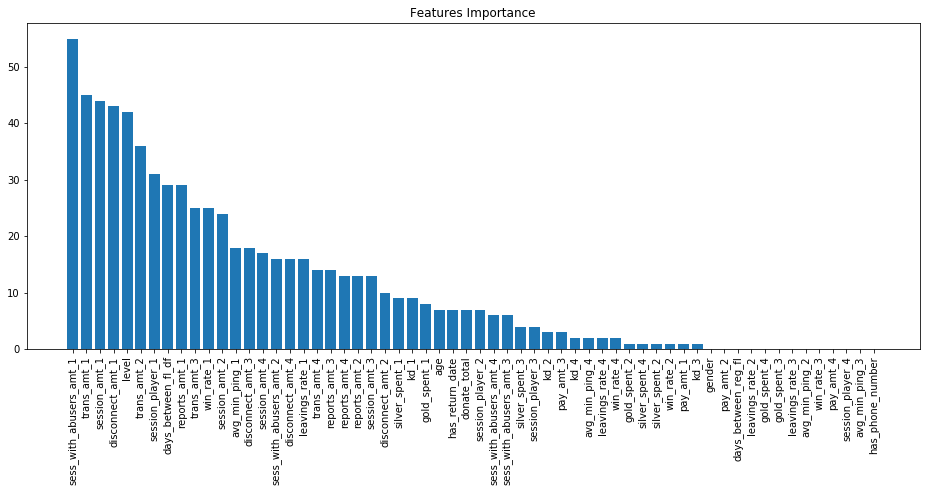

In [22]:
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

In [23]:
# Построим модель на первых 30 признаках
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = lgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

Precision: 0.2946156451066712
Recall: 0.41947926711668276
F1: 0.3461308931768451
Log Loss: 0.12985161864673306
ROC AUC: 0.9072143406565439


RandomForestClassifier

In [24]:
# Функция обучения модели и ее предсказания
def rfc_fit_predict(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(max_depth=5,
                            n_estimators=100,
                            max_leaf_nodes=20,
                            n_jobs=4,
                            random_state=42)

    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [25]:
fitted_clf = rfc_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.25229174970107615
Recall: 0.45781099324975894
F1: 0.3253104925053533
Log Loss: 0.1832418675484194
ROC AUC: 0.9054529449400668


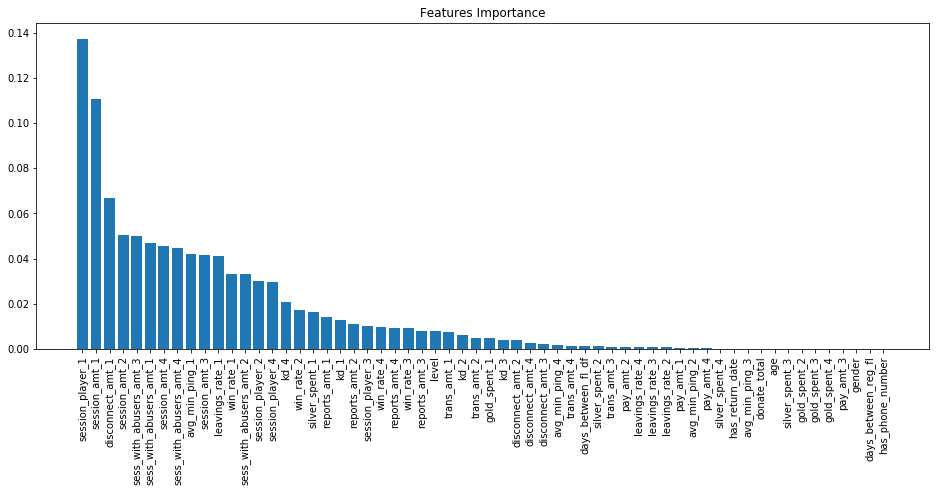

In [26]:
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

Из результатов видно, что LGBMClassifier показал лучшие результаты на одних и тех же параметрах что и XGBoost. Понятно, что дополнительно, для лучших результатов, надо подбирать параметры модели.

### 3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [27]:
# Функция вывода матрицы корреляции
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

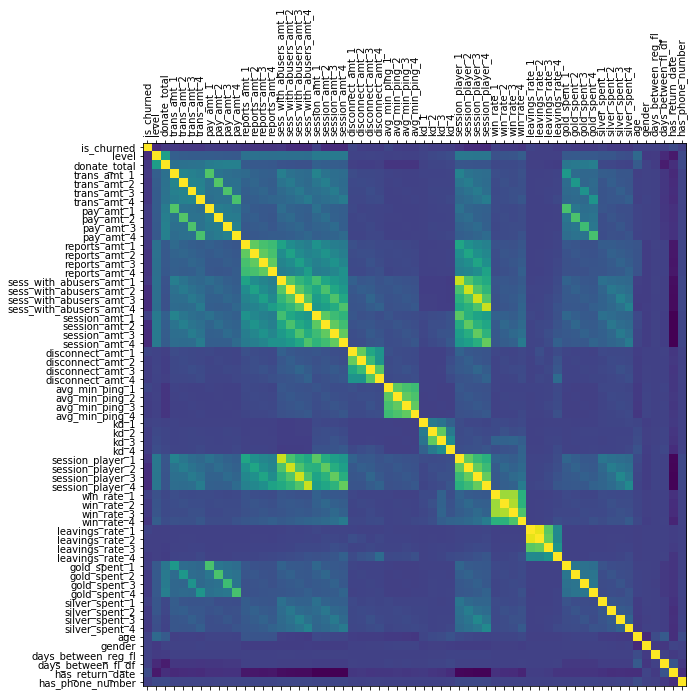

In [28]:
plot_corr(train_new)

In [29]:
# Более детальна, но громоздкая матрица корреляции
train_new.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

Есть метод Correlation-based feature selection (CFS). Его суть заключается в том что хорошие признаки высоко коррелируются с целевой переменной, но не коррелируются между собой. В нашем случае мы видим, что таких признаков нет и нам надо воспользоваться другими методами отбора признаков.